In [1]:
import pandas as pd
import math
import numpy as np
import os
from matplotlib import pyplot

In [12]:

## Run Percolator
def run_percolator(pin_file, out_target, out_decoy):
    os.system("percolator -i 10 --default-direction MainScore \
    --testFDR 0.01 --trainFDR 0.01 --results-psms "+out_target+" \
    --decoy-results-psms "+out_decoy+" -P random_ -Y -U "+pin_file)

## Based on the results from Percolator, it extracts top-scored PRSMs
## from the pXg result.
def select_top_scored_pxg_res(pxg_res_file, p_target_file, p_decoy_file):
    pxg_res = pd.read_table(pxg_res_file)
    p_target = pd.read_table(p_target_file)
    p_decoy = pd.read_table(p_decoy_file)
    
    ## remove "random_" mark in decoy
    p_decoy = p_decoy.replace({'random_': ''}, regex=True)
    
    df = pd.DataFrame(columns=pxg_res.columns)
    df['percolator_score'] = 0

    ## mak
    id_dict = {}
    score_dict = {}
    for idx in p_target.index:
        id_dict[p_target['PSMId'][idx]] = p_target['proteinIds'][idx]
        score_dict[p_target['PSMId'][idx]] = p_target['score'][idx]
    
    for idx in p_decoy.index:
        id_dict[p_decoy['PSMId'][idx]] = p_decoy['proteinIds'][idx]
        score_dict[p_decoy['PSMId'][idx]] = p_decoy['score'][idx]

    #SpecID
    #GenomicID
    for idx in pxg_res.index:
        spec_id = pxg_res['SpecID'][idx]
        genomic_id = pxg_res['GenomicID'][idx]
        if spec_id in id_dict:
            if int(id_dict[spec_id]) == int(genomic_id):
                df.loc[len(df)] = pxg_res.iloc[idx]
                df['percolator_score'][len(df)-1] = score_dict[spec_id]
    
    
    return df

## Estimate global FDR
def run_global_fdr(df, target_fdr, desc = "NONE"):
    
    target_cnt = 0
    decoy_cnt = 0
    target_idx = 0
    
    x_max = max(df['percolator_score'])
    x_min = min(df['percolator_score'])
    
    bins = np.linspace(x_min, x_max, 100)
    pyplot.title(desc)
    pyplot.hist(df[df['Label']==1]['percolator_score'], bins, alpha=0.5, label='target')
    pyplot.hist(df[df['Label']==-1]['percolator_score'], bins, alpha=0.5, label='decoy')
    pyplot.legend(loc='upper right')
    pyplot.show()
    
    ## Pass stat.
    estimated_fdr = 0
    estimated_target = 0
    estimated_decoy = 0
    for idx in df.index:
        label = df['Label'][idx]
        
        if label == 1:
            target_cnt += 1
        elif label == -1:
            decoy_cnt += 1
        
        if target_cnt != 0:
            fdr = decoy_cnt/target_cnt
            
            # pass target FDR?
            if fdr < target_fdr:
                target_idx = idx
                estimated_fdr = fdr
                estimated_target = target_cnt
                estimated_decoy = decoy_cnt
    
    print("FDR at "+str(estimated_fdr))
    print("# of targets: "+ str(estimated_target))
    print("# of decoys: "+ str(estimated_decoy))
    
    pass_df = df.iloc[0:(target_idx+1)]
    pass_df = pass_df[pass_df['Label'] == 1]
    
    return pass_df

## Estimate separate FDR (canonical and noncanonical)
def run_separate_fdr(filter_df, target_fdr):
    filter_df = filter_df.sort_values(by=['percolator_score'], ascending=False)
    
    ## Separte canonical and noncanonical PSMs
    canonical_list = filter_df[filter_df['IsCanonical'] == True]
    noncanonical_list = filter_df[filter_df['IsCanonical'] == False]
    
    return (run_global_fdr(canonical_list, target_fdr, "Canonical PSMs"), run_global_fdr(noncanonical_list, target_fdr, "Noncanonical PSMs"))
        
    
    

Protein decoy-prefix used is random_
All files have been read
Percolator version 3.06.1, Build Date Jun 15 2023 15:03:57
Copyright (c) 2006-9 University of Washington. All rights reserved.
Written by Lukas Käll (lukall@u.washington.edu) in the
Department of Genome Sciences at the University of Washington.
Issued command:
percolator -i 10 --default-direction MainScore --testFDR 0.01 --trainFDR 0.01 --results-psms toy.target.psm --decoy-results-psms toy.decoy.psm -P random_ -Y -U toy.pXg.pin
Started Thu Jun 22 17:07:57 2023
Hyperparameters: selectionFdr=0.01, Cpos=0, Cneg=0, maxNiter=10
Reading tab-delimited input from datafile toy.pXg.pin
Features:
MainScore Log2Reads Charge2 Charge3 Charge4 ppm DeltaScore MeanQScore 
Found 7723 PSMs
Separate target and decoy search inputs detected, using target-decoy competition on Percolator scores.
Train/test set contains 5827 positives and 1896 negatives, size ratio=3.07331 and pi0=1
Selecting Cpos by cross-validation.
Selecting Cneg by cross-valida

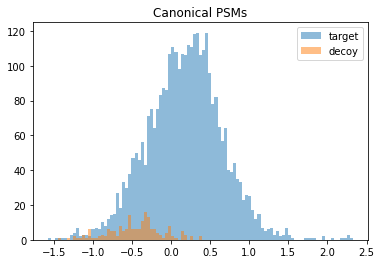

FDR at 0.04975278121137206
# of targets: 3236
# of decoys: 161


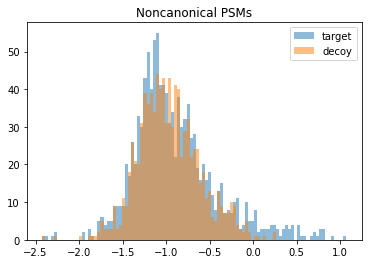

FDR at 0.04
# of targets: 50
# of decoys: 2


In [13]:

if __name__ == '__main__':
    
    run_percolator("toy.pXg.pin", "toy.target.psm", "toy.decoy.psm")
    
    ## select top-scored PRSMs in the pXg result file.
    df = select_top_scored_pxg_res("toy.pXg", "toy.target.psm", "toy.decoy.psm")
    
    ## c_df and nc_df contain target PSMs passing a given FDR threshold
    ## in canonical and noncanonical, respectively
    c_df, nc_df = run_separate_fdr(df, 0.05)
    
